In [8]:
import matplotlib.pyplot as plt
from botorch.optim import optimize_acqf
from gpytorch.kernels import RBFKernel,ScaleKernel
from gpytorch.means import ZeroMean
from botorch.models.gp_regression import FixedNoiseGP
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)



warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

In [9]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
import numpy as np
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# try

In [12]:
#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

r"""
Analytic Acquisition Functions that evaluate the posterior without performing
Monte-Carlo sampling.
"""
from botorch.acquisition import AnalyticAcquisitionFunction

from __future__ import annotations

import math

from abc import ABC

from contextlib import nullcontext
from copy import deepcopy

from typing import Dict, Optional, Tuple, Union

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.exceptions import UnsupportedError
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import Model
from botorch.utils.constants import get_constants_like
from botorch.utils.probability import MVNXPB
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform
from torch import Tensor


In [13]:
class LogGP_EI(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        c: Union[float, Tensor],
        f_mean: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("best_f", torch.as_tensor(best_f))
        self.register_buffer("c", torch.as_tensor(c))
        self.register_buffer("f_mean", torch.as_tensor(f_mean))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        mu = mean+self.f_mean
        C = self.c+self.best_f
        out = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)

  
        return out

In [14]:
class LogGP_TEI(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        c: Union[float, Tensor],
        f_mean: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("best_f", torch.as_tensor(best_f))
        self.register_buffer("c", torch.as_tensor(c))
        self.register_buffer("f_mean", torch.as_tensor(f_mean))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        
        mu = mean+self.f_mean
        C = self.c+self.best_f
        part1 = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)
        
        C = self.c
        part2 = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)
        
        out_temp = part1-part2
        
        part3 = self.best_f*Phi(  (math.log(self.c)-mu) /sigma ) 
    
        out = out_temp+part3

  
        return out

In [9]:
class ERM(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        fstar: Union[float, Tensor],
        mean_temp: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("fstar", torch.as_tensor(fstar))
        self.register_buffer("mean_temp", torch.as_tensor(mean_temp))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean_g, sigma_g = self._mean_and_sigma(X)
        mean_g = mean_g + self.mean_temp

        mu_f = self.fstar + 1/2*mean_g**2
        sigma_f = mean_g**2 * sigma_g

        gamma = (mu_f - self.fstar)/sigma_f      
        out=sigma_f * phi(gamma) + (mu_f - self.fstar) * Phi(gamma)

  
        return out

In [10]:
class EI(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("best_f", torch.as_tensor(best_f))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)

        z = (self.best_f - mean)/sigma     
        out=(self.best_f - mean) * Phi(z) + sigma * phi(z)
  
        return out

In [11]:
class LCB(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        beta: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("beta", torch.as_tensor(beta))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        
        out= -(mean - self.beta*sigma)
        return out

In [12]:
class MES(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        fstar: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("fstar", torch.as_tensor(fstar))
        self.maximize = maximizebeta

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        
        gamma = -(self.fstar-mean)/sigma

        cdf_part = Phi(gamma)
        out = (gamma*phi(gamma))/(2*cdf_part)-torch.log(cdf_part)

        return out

In [15]:
fun = Ackley(dim=7,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = min(10*dim,60)
exp_num = 1

fstar =   0.
fun = Trans_function(fun,fstar,min=True)

batch_size = 1
NUM_RESTARTS = 3*dim
RAW_SAMPLES = 30*dim

In [44]:
BO_EI = []

for N in range(exp_num):

    print(N)

    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)

    best = Y_BO.min().item()
    best_record = [best]

    for i in range(iter_num):  # Run until TuRBO converges
        #print(i)
        # Fit a GP model
        train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)

        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)

        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        # train the GP
        res = optimise(train_X,train_Y)



        covar_module = ScaleKernel(RBFKernel())
        model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
        
        model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
        model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))


        # Create a batch
        AF = EI(model=model, best_f=torch.tensor(train_Y).min()) .to(device)
        X_next_normalized, _ = optimize_acqf(
            acq_function=AF,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
        )

        X_next = unnormalize(X_next_normalized, bounds)


        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_record.append(Y_BO.min())
        
    best_record = np.array(best_record)+fstar    
    BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [45]:
BO_MES = []

for N in range(exp_num):

    print(N)

    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)

    best = Y_BO.min().item()
    best_record = [best]
    
    fstar_mes = 0. 

    for i in range(iter_num):  # Run until TuRBO converges
        #print(i)
        # Fit a GP model
        train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)

        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)

        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
        fstar_standard = fstar_standard.item()
    
        # train the GP
        res = optimise(train_X,train_Y)



        covar_module = ScaleKernel(RBFKernel())
        model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
        
        model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
        model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))


        # Create a batch
        AF = MES(model=model, fstar=fstar_standard) .to(device)
        X_next_normalized, _ = optimize_acqf(
            acq_function=AF,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
        )

        X_next = unnormalize(X_next_normalized, bounds)


        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_record.append(Y_BO.min())
    
    best_record = np.array(best_record)+fstar    
    BO_MES.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [39]:
Warped_BO_EI = []

for N in range(exp_num):
    
    print(N)

    seed = N

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
            train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(warp_Y_standard),train_yvar.expand_as(torch.tensor(warp_Y_standard)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))

            
            log_EI = LogGP_EI(model=model, best_f=Y_BO.min(),c=torch.tensor(c) , f_mean=torch.tensor(mean_warp_Y)) .to(device)
            standard_next_X, _ = optimize_acqf(
                acq_function=log_EI,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )
        
            X_next = unnormalize(standard_next_X, bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [26]:
Warped_BO_TEI = []

for N in range(exp_num):
    
    print(N)

    seed = N

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(60):
            
            print(i)
            train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(warp_Y_standard),train_yvar.expand_as(torch.tensor(warp_Y_standard)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.tensor(res[1])

            
            log_TEI = LogGP_TEI(model=model, best_f=Y_BO.min(),c=c , f_mean=mean_warp_Y) .to(device)
            standard_next_X, val = optimize_acqf(
                acq_function=log_TEI,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )

           
            X_next = unnormalize(standard_next_X, bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            print(X_next)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI.append(best_record)

0
0
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[ -7.6983,  18.6598,  32.7680,   6.5214,   2.6978,  32.7680, -29.7012]])
19.79565601261103
1
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[ 23.1356,  -3.4220,   4.0588, -28.2243,  10.5559,  32.7680, -22.0286]])
19.79565601261103
2
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[-11.1900,   5.7662,  -4.0571,  -8.2900, -10.8216,  32.7680,  -0.3689]])
19.79565601261103
3
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[-32.7680,  32.7680,  32.7680,  32.7680, -32.7680, -31.7967,  32.7680]])
19.79565601261103
4
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[ 32.7680, -32.7680, -32.7680, -32.7680, -32.7680, -32.7680,  32.7680]])
19.79565601261103
5
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[-32.7680,  32.7680, -32.7680, -32.7680, -32.7680, -32.7680,  32.7680]])
19.79565601261103
6
lengthscale is:  0.6
variance is:  0.01
c is:  1e-05
tensor([[-0.2958,  

In [25]:
model.covar_module.outputscale

tensor(0.1000, dtype=torch.float64, grad_fn=<SoftplusBackward0>)

In [17]:
Y_BO.shape

torch.Size([78, 1])

In [18]:
Y_BO.min()

tensor(19.7957, dtype=torch.float64)

In [14]:
model.covar_module.base_kernel.lengthscale 

tensor([[0.6000]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

In [15]:
 model.covar_module.outputscale

tensor(0.1000, dtype=torch.float64, grad_fn=<SoftplusBackward0>)

In [24]:
XX = torch.tensor([[ -7.6983,  18.6599,  32.7680,   6.5215,   2.6979,  32.7680, -29.7012]])
log_TEI.forward(XX)

tensor([1.6200], dtype=torch.float64, grad_fn=<AddBackward0>)

In [23]:
XX = torch.tensor([[-29.4043,  32.7680,  32.7680,  32.5416,   7.9526,  32.7680, -32.7680]])
log_TEI.forward(XX)

tensor([1.6200], dtype=torch.float64, grad_fn=<AddBackward0>)

In [20]:
BO_ERM = []
for N in range(exp_num):
    
    print(N)

    seed = N
    
    fstar0 = 0.
    Trans = False

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
                [fun(x) for x in X_BO], dtype=dtype, device=device
            ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

        #print(iter)
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        

        fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
        fstar_standard = fstar_standard.item()
        
        train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)
        
        if not Trans:
            minimal = np.min(train_X)
            res = optimise(train_X,train_Y)
                        
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))
            

            # Create a batch
            AF = EI(model=model, best_f=torch.tensor(train_Y).min()) .to(device)
            
            X_next_normalized, _ = optimize_acqf(
            acq_function=AF,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
                )

            beta = math.sqrt(math.log(train_X.shape[0]))
            
            AF = LCB(model=model, beta=beta) .to(device)
            
            _, val = optimize_acqf(
            acq_function=AF,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
                )
            
            lcb = - val
            
        
            if lcb < fstar_standard:
                Trans = True
            
            print(beta)
            print(lcb)
            print(fstar_standard)
            print(Trans)
        
        else:    
            print(Trans)                    
            train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
            mean_temp = np.mean(train_Y_transform)
            
            res = optimise(train_X,(train_Y_transform-mean_temp))
            
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y_transform-mean_temp),train_yvar.expand_as(torch.tensor(train_Y_transform-mean_temp)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))
            
            
            AF = ERM(model=model, fstar=torch.tensor(fstar_standard),mean_temp=torch.tensor(mean_temp)) .to(device)
            
            X_next_normalized, _ = optimize_acqf(
            acq_function=AF,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
                )
            
            
        
        
        X_next = unnormalize(X_next_normalized, bounds).reshape(-1,dim)     
        Y_next = fun(X_next).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_value = float(Y_BO.min())
        best_record.append(best_value)


    best_record = np.array(best_record)+fstar
    BO_ERM.append(best_record)

0
1.6651092223153954
tensor(-2.0731, dtype=torch.float64)
-0.8034581387325437
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Text(0.5, 1.0, 'Branin')

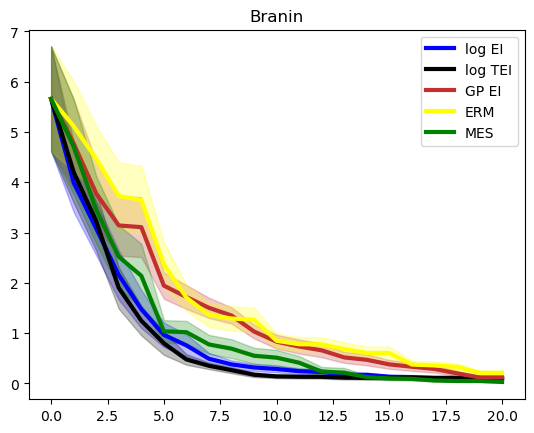

In [46]:
fstar = 0.397887
N = 20

total_record = (np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log TEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(BO_ERM)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='ERM',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='MES',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

plt.legend()
plt.title('Branin')

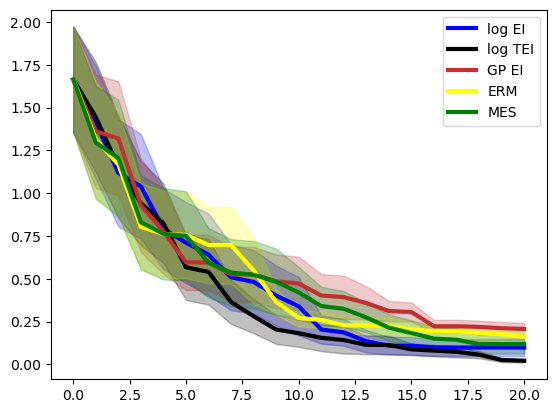

In [75]:
fstar = 0.
N = 20

total_record = (np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log TEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(BO_ERM)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='ERM',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='MES',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

plt.legend()

In [4]:
from botorch.acquisition import qKnowledgeGradient
from botorch.utils.sampling import manual_seed
import os
import math
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood


SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [5]:
fun = Beale(negate=True)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
exp_num = 20

batch_size = 1
NUM_RESTARTS = 3*dim
RAW_SAMPLES = 30*dim

In [11]:
BO_KG = []

for N in range(exp_num):

    print(N)

    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)

    best = Y_BO.max().item()
    best_record = [best]

    for i in range(iter_num):  # Run until TuRBO converges
        #print(i)
        # Fit a GP model
        train_yvar = torch.tensor(10**(-5), device=device, dtype=torch.float32)

        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)

        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        # train the GP
        res = optimise(train_X,train_Y)



        covar_module = ScaleKernel(RBFKernel())
        model = FixedNoiseGP(torch.tensor(train_X,device=device, dtype=torch.float32), torch.tensor(train_Y,device=device, dtype=torch.float32),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
        
        model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
        model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))


        # Create a batch
        qKG = qKnowledgeGradient(model, num_fantasies=20)
        with manual_seed(1234):
            X_next_normalized, _ = optimize_acqf(
                acq_function=qKG,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )

        X_next = unnormalize(X_next_normalized, bounds)


        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_record.append(Y_BO.max())
        print(Y_BO.max())
        
    best_record = np.array(best_record)    
    BO_KG.append(best_record)

0


InputDataError: Expected all inputs to share the same dtype. Got torch.float32 for X, torch.float64 for Y, and torch.float64 for Yvar.

Text(0.5, 1.0, 'Branin')

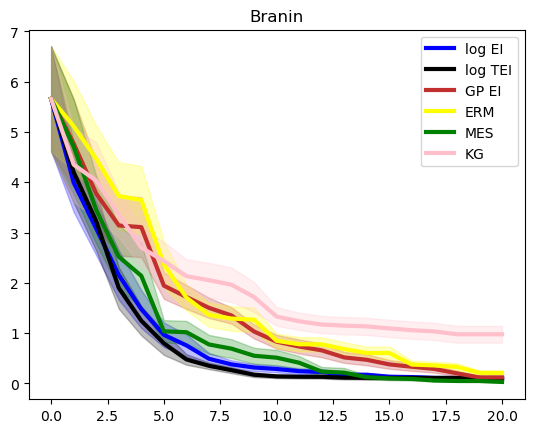

In [91]:
fstar = 0.397887
N = 20

total_record = (np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log TEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(BO_ERM)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='ERM',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='MES',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

total_record = -np.array(BO_KG)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='KG',color='pink')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='pink')

plt.legend()
plt.title('Branin')

In [94]:
total_record = np.array(BO_KG)
np.mean(total_record,axis=0)

array([-9.62640706, -8.13461261, -6.1876717 , -5.85302005, -5.60994068,
       -5.60994068, -4.53643884, -4.50381049, -4.50381049, -4.15311328,
       -4.05162687, -4.05162687, -3.99233312, -3.47152631, -3.26932876,
       -3.26932876, -3.26932876, -3.11867907, -3.03409908, -3.03409908,
       -2.82769452])

[array([29.57801281, 28.25622368, 28.25622368, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565]),
 array([30.50484961, 30.50484961, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565]),
 array([31.83243845, 31.83243845, 28.37565613, 28.37565613, 28.37565613,
        28.37565613, 28.37565613, 28.37565613, 28.37565613, 28.37565613,
        28.37565613, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565, 27.70290565, 27.70290565, 27.70290565, 27.70290565,
        27.70290565]),
 array([32.2428981 , 31.29798698, 29.12177849, 29.12177

In [54]:
torch.tensor(train_X,device=device, dtype=dtype)

tensor([[0.4751, 0.5925],
        [0.5788, 0.0371],
        [0.9507, 0.8623],
        [0.1205, 0.2614],
        [0.2149, 0.9742],
        [0.8538, 0.4035],
        [0.7421, 0.6955],
        [0.3142, 0.1725]], dtype=torch.float64)

In [55]:
torch.tensor(train_Y,device=device, dtype=dtype)

tensor([[ 0.4412],
        [ 1.3100],
        [-1.5027],
        [-0.4596],
        [ 0.4492],
        [ 0.5863],
        [-1.3434],
        [ 0.5191]], dtype=torch.float64)

In [63]:
import os
import math
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood


SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [74]:
bounds = torch.stack([torch.zeros(2), torch.ones(2)])

train_X = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(20, 2)
train_Y = torch.sin(2 * math.pi * train_X[:, [0]]) * torch.cos(
    2 * math.pi * train_X[:, [1]]
)

train_Y = standardize(train_Y + 0.05 * torch.randn_like(train_Y))

model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [75]:
train_X.dtype

torch.float32

In [76]:
train_Y.dtype

torch.float32

In [65]:
from botorch.acquisition import qKnowledgeGradient


NUM_FANTASIES = 128 if not SMOKE_TEST else 4
qKG = qKnowledgeGradient(model, num_fantasies=NUM_FANTASIES)

In [67]:
from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4


with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=qKG,
        bounds=bounds,
        q=1,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )